In [1]:
import abjad
%load_ext abjad.ext.ipython

## Abstraction and Encapsulation
The last notebook gave us a series of steps that together generate music, but they clearly divide up into several different code blocks that each accomplish a different specific task. Wouldn't it be nice to reuse these blocks if useful? In this notebook, we will clean up our procedural code and encapsulate it into several reusable functions.

### 1. Global Configuration
Even if you encapsulate your code into reusable functions, you'll often find that you need to start with some important high-level variables that you've composed, as inputs to your functions later:

In [2]:
# THIS IS THE INPUT TO MY MUSICAL IDEA
time_signature_pairs = [(4, 4), (3, 4), (7, 16), (6, 8)]
counts = [1, 2, -3, 4]
denominator = 16
pitches = abjad.CyclicTuple([0, 3, 7, 12, 7, 3])

### 2. Leaf-Generating Function
You'll recall that a large first block of code generated durated leaves. Let's pack that code into its own function.

In [9]:
def make_basic_rhythm(time_signature_pairs, counts, denominator):
    # THIS IS HOW WE MAKE THE BASIC RHYTHM
    total_duration = sum(abjad.Duration(pair) for pair in time_signature_pairs)
    talea = abjad.rhythmmakertools.Talea(counts=counts, denominator=denominator)
    talea_index = 0
    all_leaves = []
    current_duration = abjad.Duration(0)
    while current_duration < total_duration:
        leaf_duration = talea[talea_index]
        if leaf_duration > 0:
            pitch = abjad.NamedPitch("c'")
        else:
            pitch = None
        leaf_duration = abs(leaf_duration)
        if (leaf_duration + current_duration) > total_duration:
            leaf_duration = total_duration - current_duration
        current_leaves = abjad.LeafMaker()([pitch], [leaf_duration])  
        all_leaves.extend(current_leaves)
        current_duration += leaf_duration
        talea_index += 1
    music = abjad.Container(all_leaves) 
    return music

### 3. Leaf-Chopping and Measure-Wrapping Function
Another block of code chopped the generated leaves as measure boundaries. Let's wrap that in its own function.

In [10]:
def clean_up_rhythm(music, time_signature_pairs):
    # THIS IS HOW WE CLEAN UP THE RHYTHM
    shards = abjad.mutate(music[:]).split(time_signature_pairs)
    for i, shard in enumerate(shards):
        measure = abjad.Measure(time_signature_pairs[i])
        abjad.mutate(shard).wrap(measure)
    return music

### 4. Leaf-Pitching Function
The next block of code iterated through the music's tie chains and pitched each one according to our cycle of pitches. It can be a function, too:

In [11]:
def add_pitches(music, pitches):
    # THIS IS HOW WE ADD PITCHES
    pitches = abjad.CyclicTuple(pitches)
    logical_ties = abjad.iterate(music).by_logical_tie(pitched=True)
    for i, logical_tie in enumerate(logical_ties):
        pitch = pitches[i]
        for note in logical_tie:
            note.written_pitch = pitch
    return music


### 5. Compositional-Detailing Function
Finally, we iterated through runs of leaves and added compositional detailing:

In [12]:
def add_attachments(music):
    # THIS IS HOW WE ADD DYNAMICS AND ACCENTS
    for run in abjad.select(music).by_leaf().by_run((abjad.Note, abjad.Chord)):
        abjad.attach(abjad.Articulation('accent'), run[0])
        if 1 < len(run):
            abjad.attach(abjad.Hairpin('p < f'), run)
        else:
            abjad.attach(abjad.Dynamic('ppp'), run[0])
    return music

### 6. The Music-Making Function
What do we gain from encapsulation like this? We can now create a single function that reuses each of these functions:

In [13]:
def make_music(time_signature_pairs, counts, denominator, pitches):
    music = make_basic_rhythm(time_signature_pairs, counts, denominator)
    music = clean_up_rhythm(music, time_signature_pairs)
    music = add_pitches(music, pitches)
    music = add_attachments(music)
    return music

And we can call the function once to get music:

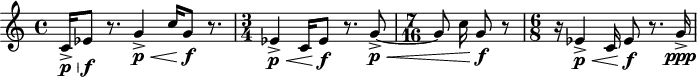

In [14]:
music = make_music(time_signature_pairs, counts, denominator, pitches)
abjad.show(music)

## Conclusion
We've now converted our procedural code into reusable functions. You might notice that we're passing the same variables into these functions, over and over. This is usually a good hint that it might be a good idea to refactor the code with an object-oriented frame of mind. In our next notebook, these reusable functions will become the methods of a music-making class.